# Time Series LSTM Algorithm

This algorithm is used to forecast FOREX prices for the USDJPY pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hourx hour

In [2]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import ta
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from UsefulFunctions import data, backtest, display

**Initiate bound between MetaTrader5 and Python**

In [4]:
# To be able to connect to MetaTrader5 you need to be already logged in with your trading account
mt5.initialize()

True

In [5]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("USDJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262,30,0
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599,30,0
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832,30,0
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761,30,0
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484,30,0


In [6]:
# Drop columns spread and real_volume and remane columns tick_volumne to volumne
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,120.42,120.44,120.33,120.39,262
2015-01-02 09:00:00,120.40,120.50,120.38,120.43,599
2015-01-02 10:00:00,120.44,120.48,120.34,120.34,832
2015-01-02 11:00:00,120.33,120.42,120.31,120.40,761
2015-01-02 12:00:00,120.41,120.47,120.37,120.43,484


## Feature engineering 
**Creating new input variables from raw data**

In [8]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy.head()

,close,pct_change
time,,
2015-01-02 08:00:00,120.39,NaN
2015-01-02 09:00:00,120.43,0.000332
2015-01-02 10:00:00,120.34,-0.000747
2015-01-02 11:00:00,120.40,0.000499
2015-01-02 12:00:00,120.43,0.000249


In [9]:
# Creating new features to train the model
df_copy2 = df_copy
df_copy2["SMA 15"] = df_copy2[["close"]].rolling(15).mean().shift(1)
df_copy2["SMA 60"] = df_copy2[["close"]].rolling(60).mean().shift(1)
df_copy2["MSD 10"] = df_copy2[["close"]].rolling(10).std().shift(1)
df_copy2["MSD 30"] = df_copy2[["close"]].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df_copy2["close"], window=30, fillna=False)
df_copy2["RSI 30"] = RSI.rsi().shift(1)

WR = ta.momentum.WilliamsRIndicator(df["high"], df["low"], df["close"], lbp=21, fillna=False)
df_copy2["WR 21"] = WR.williams_r().shift(1)

df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21
time,,,,,,,,
2015-01-06 20:00:00,118.36,-0.001013,118.910667,119.814667,0.308300,0.423147,37.046534,-72.670807
2015-01-06 21:00:00,118.62,0.002197,118.848667,119.780833,0.340361,0.415715,36.030372,-79.746835
2015-01-06 22:00:00,118.49,-0.001096,118.808000,119.750667,0.342922,0.409160,39.735411,-60.273973
2015-01-06 23:00:00,118.36,-0.001097,118.777333,119.719833,0.343455,0.420124,38.579643,-69.178082
2015-01-07 00:00:00,118.59,0.001943,118.748667,119.685833,0.283706,0.431128,37.452708,-77.142857


In [10]:
# Using the custome function "add_shifted_columns" 5 new columns are added with shifted values from close column
# Check the docstring of the "add_shifted_columns" function from the data.py file
df_copy2 = data.add_shifted_columns(df_copy2, 5, "close")
df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21,1_close_bars_ago,2_close_bars_ago,3_close_bars_ago,4_close_bars_ago,5_close_bars_ago
time,,,,,,,,,,,,,
2015-01-07 01:00:00,118.65,0.000506,118.710667,119.655167,0.240289,0.425081,40.626936,-60.714286,118.59,118.36,118.49,118.62,118.36
2015-01-07 02:00:00,118.74,0.000759,118.696000,119.624833,0.192841,0.416137,41.429091,-54.477612,118.65,118.59,118.36,118.49,118.62
2015-01-07 03:00:00,119.00,0.002190,118.690000,119.593500,0.172784,0.397710,42.631784,-47.761194,118.74,118.65,118.59,118.36,118.49
2015-01-07 04:00:00,119.06,0.000504,118.692667,119.566833,0.225657,0.383160,45.948689,-28.358209,119.00,118.74,118.65,118.59,118.36
2015-01-07 05:00:00,119.01,-0.000420,118.676000,119.539833,0.241212,0.360198,46.684583,-23.880597,119.06,119.00,118.74,118.65,118.59


## Implementing Machine Learning

In [12]:
# Splitting the data into features and labels for the ML model using the custom function "split_data" from data.py file
X = df_copy2.iloc[:,2:]
y = df_copy2["pct_change"]

# Data si splitted in training, validation and test datasets
X_train, y_train, X_temp, y_temp = data.split_data(X, y, 70)
X_val, y_val, X_test, y_test = data.split_data(X_temp, y_temp, 50)

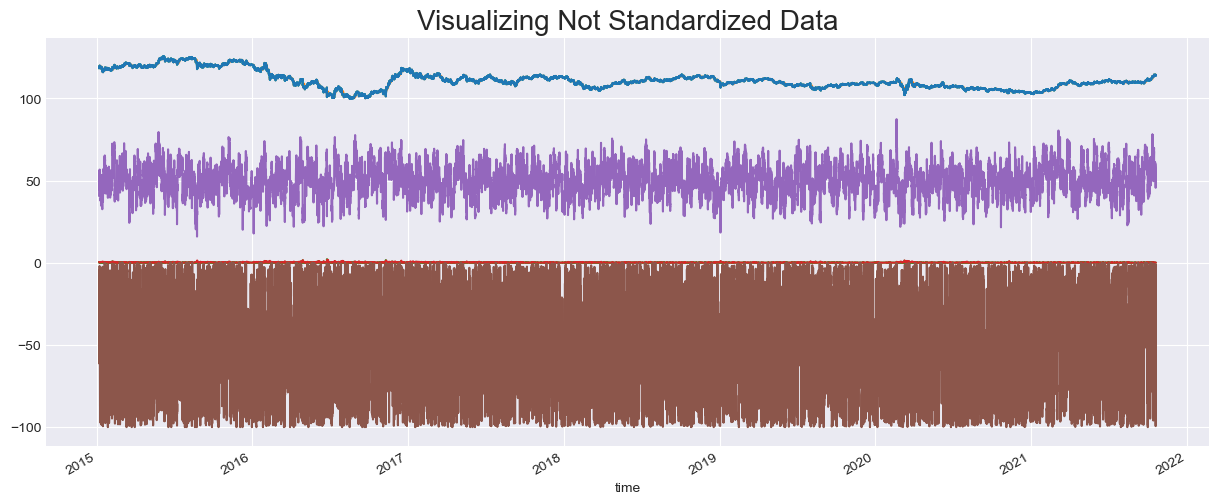

In [13]:
# Plotting features before standardization to visualize their unequal scales
X_train.plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Not Standardized Data", fontsize=20)
plt.show()

### Applying StandardScaler to Normalize Features

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

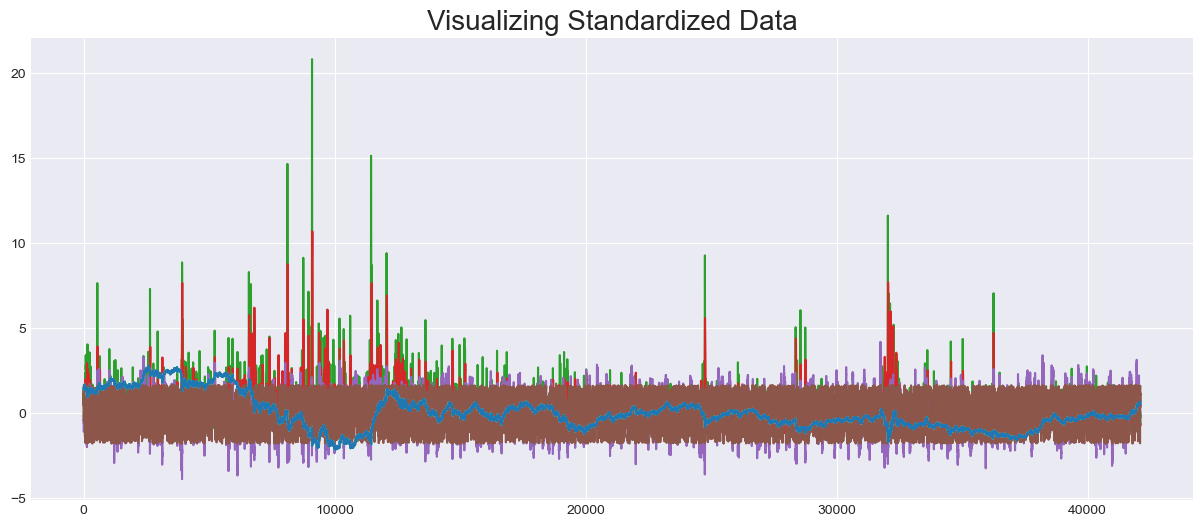

In [17]:
pd.DataFrame(X_train_scaled).plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Standardized Data", fontsize=20)
plt.show()

**Transforming 2D data into 3D datasets**

This is the proper data shape received by the LSTM algorithm

In [19]:
# Creating a function to transfor the 2D data into 3D data
def create_3d_data(X_data, y_data, lag):
    X_data_3d = []
    y_data_3d = []

    for i in range(lag, len(X_data)):
        X_data_3d.append(X_data[i-lag:i])
        y_data_3d.append(y_data[i])

    X_data_3d = np.array(X_data_3d)
    y_data_3d = np.array(y_data_3d)

    return X_data_3d, y_data_3d

In [20]:
'''
X_train_3d, y_train_3d = create_3d_data(X_train_scaled, y_train, 10)
X_val_3d, y_val_3d = create_3d_data(X_val_scaled, y_val, 10)
X_test_3d, y_test_3d = create_3d_data(X_test_scaled, y_test, 10)
'''
X_train_3d, y_train_3d = create_3d_data(X_train_scaled, np.where(y_train > 0, 1, 0), 10)
X_val_3d, y_val_3d = create_3d_data(X_val_scaled, np.where(y_val > 0, 1, 0), 10)
X_test_3d, y_test_3d = create_3d_data(X_test_scaled, np.where(y_test > 0, 1, 0), 10)


In [21]:
# Showing the new shape of the X_train dataset
print(f"Old shape of X_train dataset    {X_train_scaled.shape}")
print(f"New shape of X_train dataset    {X_train_3d.shape}")

Old shape of X_train dataset    (42107, 11)
New shape of X_train dataset    (42097, 10, 11)


**Showing the first 3D row of the new 3D data**

In [23]:
pd.DataFrame(X_train_3d[0])

,0,1,2,3,4,5,6,7,8,9,10
0,1.455490,1.635918,1.175828,1.357891,-1.093810,-0.443131,1.432096,1.388497,1.413069,1.437639,1.388360
1,1.452712,1.630164,0.705721,1.300359,-1.003257,-0.228924,1.443459,1.432052,1.388452,1.413022,1.437594
2,1.451575,1.624220,0.507000,1.181824,-0.867489,0.001761,1.460502,1.443415,1.432006,1.388404,1.412977
3,1.452080,1.619161,1.030855,1.088230,-0.493053,0.668185,1.509740,1.460458,1.443368,1.431958,1.388360
4,1.448922,1.614039,1.184973,0.940521,-0.409981,0.821975,1.521102,1.509694,1.460411,1.443320,1.431913
5,1.448544,1.610309,1.379068,0.780490,-0.471117,0.693817,1.511633,1.521057,1.509647,1.460363,1.443275
6,1.449175,1.606641,1.315129,0.738971,-0.427653,0.770712,1.517315,1.511588,1.521009,1.509597,1.460317
7,1.449175,1.602310,1.285874,0.645202,-0.650815,0.309342,1.483227,1.517269,1.511541,1.520959,1.509551
8,1.453343,1.598295,1.172137,0.627052,-0.401336,0.745080,1.515421,1.483182,1.517222,1.511491,1.520913
9,1.464206,1.594279,0.590195,0.520956,-0.357924,0.821975,1.521102,1.515376,1.483135,1.517172,1.511445


In [24]:
pd.DataFrame(y_test_3d).tail()

,0
9009,0
9010,0
9011,1
9012,1
9013,1


In [25]:
pd.DataFrame(y_test).tail()

,pct_change
time,
2024-09-11 23:00:00,-0.000042
2024-09-12 00:00:00,-0.000618
2024-09-12 01:00:00,0.001265
2024-09-12 02:00:00,0.001264
2024-09-12 03:00:00,0.001725


**Prefetching data to make the algorithms run faster**

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import os

In [28]:
# Convert both X and y datasets into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_3d, y_train_3d))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_3d, y_val_3d))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_3d, y_test_3d))

# Batch and prefetch
batch_size = 512  
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
# Creating a function to implement a ModelChechpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
    # Ensure the directory exists
    #os.makedirs(save_path, exist_ok=True)
    
    return ModelCheckpoint(
        filepath=os.path.join(save_path, f"{model_name}.keras"),
        monitor="val_loss",
        verbose=1,
        save_best_only=True
    )

In [30]:
def run_lstm(train_sets, val_sets, p_model_name, neurons=64, layers=2, p_epochs=30, lr=0.001, ptn=5, path="model_experiments"):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break
    
   
    hidden_layers = layers 
    p_model_name = Sequential(name=p_model_name)

    # Input layer
    p_model_name.add(LSTM(neurons, input_shape=(features_input_shape), return_sequences=True, name="input_layer_0"))

    # hidden layers
    for i in range(0, hidden_layers):
        p_model_name.add(LSTM(neurons, activation="tanh", return_sequences=True, name=f"hidden_layer_{i}"))
        p_model_name.add(Dropout(0.15, name=f"dropout_layer_{i}"))

    # Last hidden layer
    p_model_name.add(LSTM(neurons, activation="relu", return_sequences=False, name=f"last_hidden_layer"))

    # Output layer
    p_model_name.add(Dense(1, activation="sigmoid", name="output_layer"))
    
    checkpoint_callback = create_model_checkpoint(p_model_name.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=ptn, verbose=1)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=7, verbose=1)

    # Compiling the model
    p_model_name.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=lr), metrics=["accuracy"])

    # Training the model
    history = p_model_name.fit(train_sets,
                               validation_data=(val_sets), 
                               batch_size=512, 
                               epochs=p_epochs,
                               verbose=0,
                               callbacks=[checkpoint_callback, early_stopping, reduce_plateau]
                              )

    return history

In [31]:
history_model_1 = run_lstm(train_dataset, val_dataset, "model_1", neurons=128, layers=2, lr=0.01, ptn=7)


Epoch 1: val_loss improved from inf to 0.69315, saving model to model_experiments\model_1.keras

Epoch 2: val_loss did not improve from 0.69315

Epoch 3: val_loss did not improve from 0.69315

Epoch 4: val_loss improved from 0.69315 to 0.69294, saving model to model_experiments\model_1.keras

Epoch 5: val_loss did not improve from 0.69294

Epoch 6: val_loss did not improve from 0.69294

Epoch 7: val_loss did not improve from 0.69294

Epoch 8: val_loss did not improve from 0.69294

Epoch 9: val_loss did not improve from 0.69294

Epoch 10: val_loss did not improve from 0.69294

Epoch 11: val_loss did not improve from 0.69294

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11: early stopping


In [32]:
from tensorflow.keras.models import load_model

**Loading the Model and Showing its Architecture**

In [34]:
model_1 = load_model(f"model_experiments/{"model_1"}.keras")
model_1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (LSTM)            │ (None, 10, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_0 (LSTM)           │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_0 (Dropout)       │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (LSTM)           │ (None, 10, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer_1 (Dropout)       │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_hidden_layer (LSTM)        │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,399,685 (5.34 MB)

 Trainable params: 466,561 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 933,124 (3.56 MB)

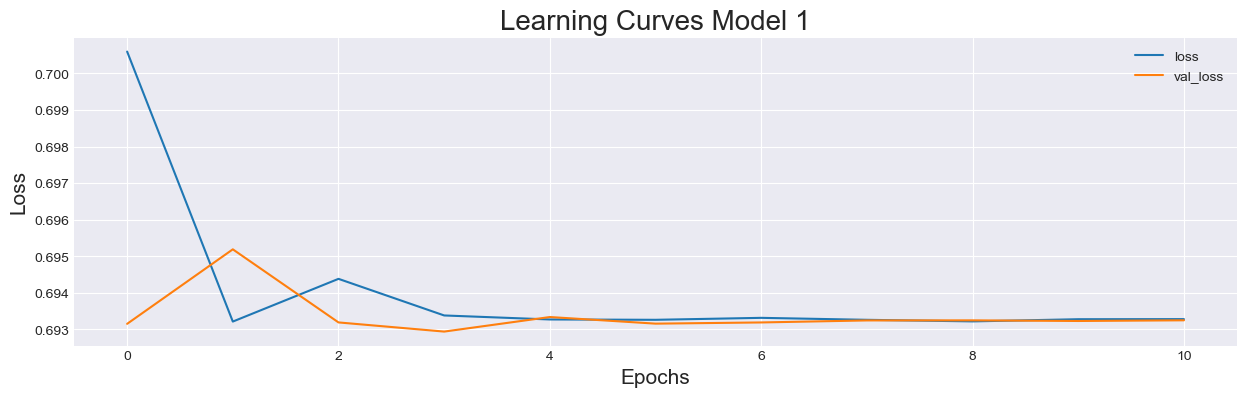

In [35]:
pd.DataFrame(history_model_1.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model 1", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [36]:
# Evaluating the model
model_1.evaluate(test_dataset)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.5159 - loss: 0.6929


[0.6929588913917542, 0.5150876641273499]

In [37]:
# Making predictions
model_1_pred = model_1.predict(X_test_3d)

282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [38]:
# Showring the shape of the predictions outcome
model_1_pred.shape

(9014, 1)

In [39]:
# transforming predictions (probabilities) into positions
test_df = pd.DataFrame(model_1_pred, columns=["prediction"])
test_df["pred_position"] = np.where(test_df["prediction"] > 0.5, 1, -1)
test_df

,prediction,pred_position
0,0.503757,1
1,0.503753,1
2,0.503746,1
3,0.503741,1
4,0.503740,1
...,...,...
9009,0.503717,1
9010,0.503720,1
9011,0.503722,1
9012,0.503726,1


In [40]:
# The original targets dataset has 9005 rows, since the lag used to make 3D data set is 10, it's required 
# to removed those firts 10 rows to match the amout of the predictions output for further analysis
pd.DataFrame(y_test)

,pct_change
time,
2023-03-31 05:00:00,-0.001578
2023-03-31 06:00:00,-0.000941
2023-03-31 07:00:00,-0.000060
2023-03-31 08:00:00,0.001657
2023-03-31 09:00:00,0.001557
...,...
2024-09-11 23:00:00,-0.000042
2024-09-12 00:00:00,-0.000618
2024-09-12 01:00:00,0.001265


In [42]:
# DataFrame with comparison of real and predicted positions, here 10 rows from original targets were removed for proper sizing
returns_model_1 = backtest.compute_strategy_returns(y_test[10:], np.where(test_df["prediction"] > 0.5, 1, -1))
returns_model_1

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2023-03-31 15:00:00,-0.000773,1,-1.0,1,-0.000773
2023-03-31 16:00:00,-0.000534,1,-1.0,1,-0.000534
2023-03-31 17:00:00,0.000549,1,1.0,1,0.000549
2023-03-31 18:00:00,-0.002487,1,-1.0,1,-0.002487
2023-03-31 19:00:00,0.000098,1,1.0,1,0.000098
...,...,...,...,...,...
2024-09-11 23:00:00,-0.000042,1,-1.0,1,-0.000042
2024-09-12 00:00:00,-0.000618,1,-1.0,1,-0.000618
2024-09-12 01:00:00,0.001265,1,1.0,1,0.001265


**Plotting the Cumulative Returns from Model 1**

Profits : 7.69%


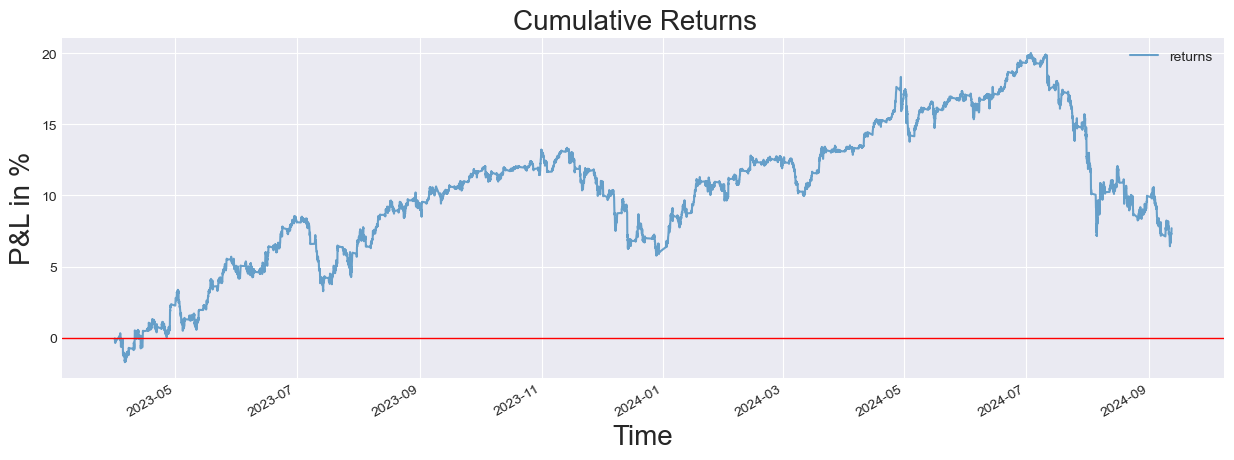

In [48]:
display.plot_test_returns(returns_model_1["returns"])

**Forecast Accuracy Analysis for Model 1**

Predicted vs. Real Positions

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
1    4643
0    4371
Name: count, dtype: int64

Model has an accuracy of: 51.51%


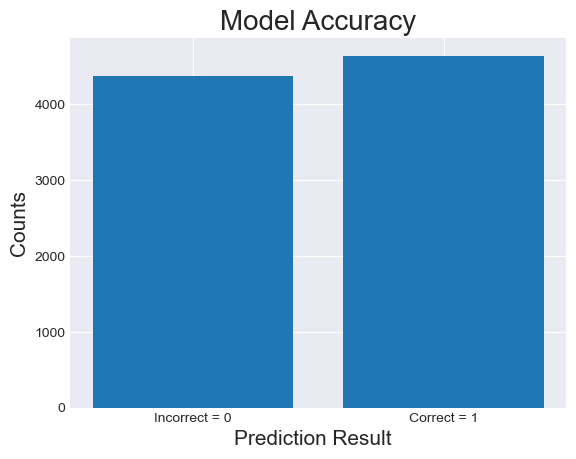

,real_position,pred_position,accuracy
time,,,
2023-03-31 15:00:00,-1.0,1,0
2023-03-31 16:00:00,-1.0,1,0
2023-03-31 17:00:00,1.0,1,1
2023-03-31 18:00:00,-1.0,1,0
2023-03-31 19:00:00,1.0,1,1


In [57]:
backtest.compute_model_accuracy(returns_model_1["real_position"], returns_model_1["pred_position"])